In [1]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque

2024-03-10 12:41:13.583191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 12:41:13.584735: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-10 12:41:13.608929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 12:41:13.608955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 12:41:13.609603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
#DQN-AGENT
class DQN:
    def __init__(self, input_shape, num_actions):
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.replay_buffer = deque(maxlen=20000) #a high enough replay-buffer size is needed to prevent catastrophic forgetting (initial value was 100.000, but I reduced it to 20.000 to save ram)
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        
        self.model = self.build_model()
        self.target_model = self.build_model()

    # build model
    def build_model(self):
        model = tf.keras.models.Sequential([
            layers.Dense(24, activation="relu", input_shape=self.input_shape), #32 units
            layers.Dense(24, activation="relu"), #32 units
            layers.Dense(self.num_actions, activation="linear")
        ])
        #compiles model with mean squared error loss and adam optimizer
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model
    
    #agent takes action based on epsilon-greedy policy
    def act(self, state, epsilon = 0.0):
        if np.random.rand() < epsilon:
            return np.random.choice(self.num_actions)
        else:
            Q_values = self.model.predict(state[np.newaxis])
            #Q_values = self.model.predict(state)
            return np.argmax(Q_values[0])
    
    #agent stores experience in replay buffer
    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    #agent samples from replay buffer and updates Q-values
    def replay(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        
        samples = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        
        #Q-values
        q_values = self.model.predict(states)
        #next Q-values from target model
        next_q_values = self.target_model.predict(next_states)
        max_next_q_values = np.max(next_q_values, axis=1)
        #calculate target Q-values using Bellman equation
        target_q_values = (rewards + (1 - dones) * self.discount_factor * max_next_q_values)
        q_values[range(batch_size), actions] = target_q_values
        self.model.fit(states, q_values, verbose=0)

    #updates target model weights with model weights
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())


In [3]:
#Preperation
keras.utils.disable_interactive_logging()
env = gym.make("CartPole-v0", render_mode="human")
num_actions = env.action_space.n
input_shape = env.observation_space.shape

#create agent
dqn = DQN(input_shape, num_actions)

/home/leon/Documents/projects/iannwtf/tf_gym/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [4]:
#training loop

#epsilon
epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995 #0.995

batch_size = 64 #32
num_episodes = 150 #500

target_update_counter = 0
#every x episode the target model is updated
target_update_freq = 8 #1


running_reward = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    while not done:
        #env.render()
        action = dqn.act(state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated or episode_reward > 200 #episode reward > 200 is probably unnecessary
        dqn.remember(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        dqn.replay(batch_size)
    
    target_update_counter += 1
    if target_update_counter % target_update_freq == 0:
        dqn.update_target_model()
        
    running_reward.append(episode_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    print(f"Episode: {episode} episode reward: {episode_reward} Epsilon: {epsilon}")

Episode: 0 episode reward: 15.0 Epsilon: 0.995
Episode: 1 episode reward: 19.0 Epsilon: 0.990025
Episode: 2 episode reward: 30.0 Epsilon: 0.985074875
Episode: 3 episode reward: 17.0 Epsilon: 0.9801495006250001
Episode: 4 episode reward: 13.0 Epsilon: 0.9752487531218751
Episode: 5 episode reward: 36.0 Epsilon: 0.9703725093562657
Episode: 6 episode reward: 57.0 Epsilon: 0.9655206468094844
Episode: 7 episode reward: 21.0 Epsilon: 0.960693043575437
Episode: 8 episode reward: 11.0 Epsilon: 0.9558895783575597
Episode: 9 episode reward: 14.0 Epsilon: 0.9511101304657719
Episode: 10 episode reward: 21.0 Epsilon: 0.946354579813443
Episode: 11 episode reward: 11.0 Epsilon: 0.9416228069143757
Episode: 12 episode reward: 34.0 Epsilon: 0.9369146928798039
Episode: 13 episode reward: 24.0 Epsilon: 0.9322301194154049
Episode: 14 episode reward: 20.0 Epsilon: 0.9275689688183278
Episode: 15 episode reward: 11.0 Epsilon: 0.9229311239742362
Episode: 16 episode reward: 34.0 Epsilon: 0.918316468354365
Episod

2024-03-10 11:44:51.832339: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Episode: 135 episode reward: 200.0 Epsilon: 0.5057535983897912
Episode: 136 episode reward: 147.0 Epsilon: 0.5032248303978422
Episode: 137 episode reward: 113.0 Epsilon: 0.500708706245853
Episode: 138 episode reward: 200.0 Epsilon: 0.4982051627146237
Episode: 139 episode reward: 54.0 Epsilon: 0.49571413690105054
Episode: 140 episode reward: 131.0 Epsilon: 0.4932355662165453
Episode: 141 episode reward: 83.0 Epsilon: 0.4907693883854626
Episode: 142 episode reward: 200.0 Epsilon: 0.4883155414435353
Episode: 143 episode reward: 34.0 Epsilon: 0.4858739637363176
Episode: 144 episode reward: 146.0 Epsilon: 0.483444593917636
Episode: 145 episode reward: 98.0 Epsilon: 0.4810273709480478
Episode: 146 episode reward: 200.0 Epsilon: 0.47862223409330756
Episode: 147 episode reward: 100.0 Epsilon: 0.47622912292284103
Episode: 148 episode reward: 139.0 Epsilon: 0.4738479773082268
Episode: 149 episode reward: 185.0 Epsilon: 0.47147873742168567


In [4]:
#load weights 
#NAME_TO_LOAD = "models/dqn_cartpole_freq1_200eps/weights.h5"

BATCH = 64
FREQ = 8
NR_EPISODE = 200
NAME_TO_LOAD = f"models/batch_size_{BATCH}/target_update_freq_{FREQ}/intermediate_results/episode_{NR_EPISODE}.h5"
dqn.model.load_weights(NAME_TO_LOAD)

In [5]:
#testing model 
test_rewards = []
for episode in range(20):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    while not done:
        env.render()
        #with epsilon = 0.0 so the agent exploits the learned policy 
        action = dqn.act(state, 0.0)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated or episode_reward > 200 #episode reward > is unnecessary
        state = next_state
        episode_reward += reward
    print(f"Test Episode: {episode} episode reward: {episode_reward}")
    test_rewards.append(episode_reward)

Test Episode: 0 episode reward: 200.0
Test Episode: 1 episode reward: 200.0
Test Episode: 2 episode reward: 200.0
Test Episode: 3 episode reward: 200.0
Test Episode: 4 episode reward: 200.0
Test Episode: 5 episode reward: 200.0
Test Episode: 6 episode reward: 200.0
Test Episode: 7 episode reward: 200.0
Test Episode: 8 episode reward: 200.0
Test Episode: 9 episode reward: 200.0
Test Episode: 10 episode reward: 200.0
Test Episode: 11 episode reward: 200.0
Test Episode: 12 episode reward: 200.0
Test Episode: 13 episode reward: 200.0
Test Episode: 14 episode reward: 200.0
Test Episode: 15 episode reward: 200.0
Test Episode: 16 episode reward: 200.0
Test Episode: 17 episode reward: 200.0
Test Episode: 18 episode reward: 200.0
Test Episode: 19 episode reward: 200.0


In [6]:
np.mean(test_rewards)

200.0

In [6]:
#save weights, rewards and model
NAME = "dqn_cartpole_freq1_200eps"

dqn.model.save(f"models/{NAME}/weights.h5")
np.save(f"models/{NAME}/rewards.npy", running_reward)

#if test_rewards is not empty
# if test_rewards:
#     np.save(f"models/{NAME}/test_rewards.npy", test_rewards)

#save architecture, replay_buffer_length, learning rate, discount factor, batch_size, epsilon_decay, target_update_frequency
with open(f"models/{NAME}/info.txt", "w") as f:
    #write model summary and other details to file
    dqn.model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write(f"Replay buffer length: {len(dqn.replay_buffer)}\n")
    f.write(f"Learning rate: {dqn.learning_rate}\n")
    f.write(f"Discount factor: {dqn.discount_factor}\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"Epsilon decay: {epsilon_decay}\n")
    f.write(f"Target update frequency: {target_update_freq}\n")
    f.write(f"Episodes: {num_episodes}\n")

/home/leon/Documents/projects/iannwtf/tf_gym/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
import matplotlib.pyplot as plt
#loads rewards and plots them together
def plot_rewards(names):
    for name in names:
        rewards = np.load(f"models/{name}/rewards.npy")
        plt.plot(rewards, label=name)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

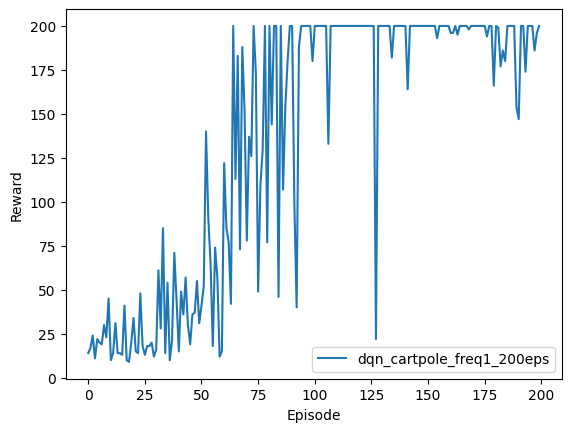

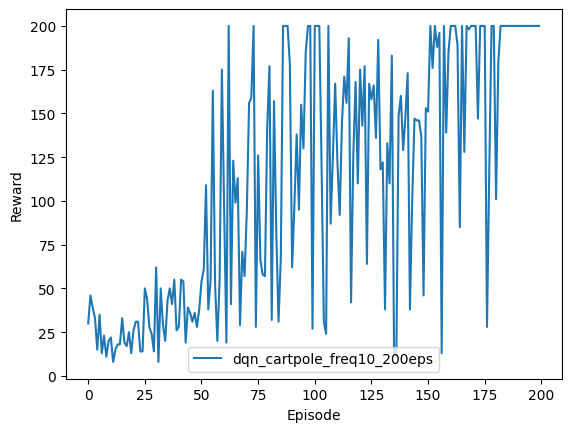

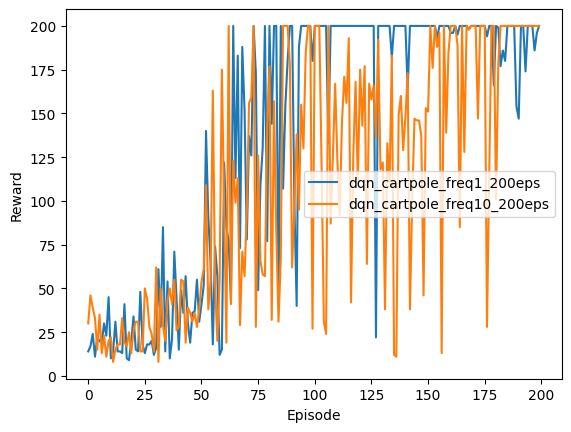

: 

In [8]:
# Our current testing results for different target_network update frequencies:
# NOTE THAT THE MODEL IS TRAINED FOR 200 EPISODES AND IS NOT OPTIMAL IN TESTING
plot_rewards(["dqn_cartpole_freq1_200eps"])
plot_rewards(["dqn_cartpole_freq10_200eps"])
plot_rewards(["dqn_cartpole_freq1_200eps", "dqn_cartpole_freq10_200eps"])